# __Uncovering the Patterns of Tornadoes in the USA: A Data Science Approach__ #

## __Intro to the Project__ ##
This is a personal project that focuses on one of my main interests using the field that I wish to pursue in my upcoming professional career. The interest in question is meteorology, and the field is data science. I will be taking aspects from both of these subjects and using aspects from one to analyze, visualize, and present conclusions derived from aspects of the other.

The specific area in meteorology being focused on is the behavior of tornadoes in the United States, and specifically the 48 contiguous states, as this is where the vast majority of tornadoes around the world occur, and as such, where the most readily available data exists. The data that is being used for this project comes from the following source: https://www.kaggle.com/datasets/danbraswell/us-tornado-dataset-1950-2021

The "behavior" that is being focused on with this project pertains to location, strength, and time:
- Location refers to the starting latitude and longitude of the tornadoes. For this project, we will only be including tornado behavior in the lower 48, so all rows with an AK, HI, PR, or VI tag for the state will be ignored in the initial parsing and, as such, not included in the data being used for the project. There may be some data points just over the border of the US in some spots, but that is only because those tornadoes ended in the US, and we are using starting points only in our location data.
- Strength merely refers to the rating of the tornado on the Fujita or the Enhanced Fujita scale. Please note that as I was working on this project, I noticed a large number of flawed data points that list rating as -9, making any real analysis of the data involving tornado strength at least slightly inaccurate. As such, those data points will be excluded in any analysis involving strength at the cost of some lost data.
- Time refers to the year, month, and day that the tornado formed on. This presents a challenge in terms of the numerical analysis that will be done, as if I want a true representation of the time of occurrence, I will need to find a way to represent this as a single integer/float value that is both able to be transformed back into the year, month, day format and be used in an effective numerical analysis. To achieve this, I will be using the tornado's age in years using midnight on January 1st, 2025, as the target date. This will be calculated as follows:
- Average number of days in a month = (0.75)(365/12) + (0.25)(366/12) = 30.4375
- Average year length = (0.75)(365) + (0.25)(366) = 365.25
- Age in years = 2025 - year - ((month*30.4375 + day)/365.25)
- Note that this is not completely accurate, as slight variation in the length of months as well as other small inaccuracies result in the value we find being ever so slightly off.

Now that the general idea of the project is explained, let's get onto the first steps.

## __Parsing the Dataset__ ##

In [1]:
#importing necessary libraries
#note that folium requires the command !pip install folium if it is not already installed to be executed prior to the import command
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv
import folium as fl
from folium.plugins import MarkerCluster
from sklearn.cluster import DBSCAN
#set array print options for more stable viewing
np.set_printoptions(suppress=True, precision=5)

In [2]:
#open and read csv via csv library
f=open("us_tornado_dataset_1950_2021.csv")
reader=csv.reader(f, delimiter=',')
#data_Matrix will hold our final data points that will be transformed into a numpy matrix and used for our analysis
#attributes holds the identifiers for each column
data_Matrix = list()
attributes = list()
#first row is identifiers, move to attributes list
i=0
for row in reader:
    if i==0:
        attributes = row
        i+=1
        continue
    #ignore all Hawaii and Alaska tornadoes
    if row[4] == 'AK' or row[4] == 'HI' or row[4] == 'PR' or row[4] == 'VI':
        continue
    #ignore incorrect data point in mexico
    if float(row[8]) < 26.910278 and float(row[9]) < -101.422222:
        continue
    #all other rows need to be parsed and entered into our array via cur_list
    #cur_list  contains our target attributes for the current row, and is refreshed on every loop to a new empty list
    cur_row = list()
    #add year and month to list
    cur_row.append(row[0])
    cur_row.append(row[1])
    #Calculate age value and add to list
    year = float(row[0])
    month = float(row[1])
    day = float(row[2])
    age = 2025 - year - (((month*30.4375) + day)/365.25)
    cur_row.append(age)
    #Add strength to list
    cur_row.append(row[5])
    #add lat and long to list
    cur_row.append(row[8])
    cur_row.append(row[9])
    #Add list as a new row to our matrix
    data_Matrix.append(cur_row)
#convert 2D python list to a 2D numpy array of datatype d (float, double precision)
data_matrix = np.array(data_Matrix,dtype='d')
#close file
f.close()

## __First Look at the Data__ ##
Now that we have parsed the data and moved it into our environment, let's take a look at what we have to work with:

First, we have the attributes list:

In [3]:
print(attributes)

['yr', 'mo', 'dy', 'date', 'st', 'mag', 'inj', 'fat', 'slat', 'slon', 'elat', 'elon', 'len', 'wid']


The attributes identify the following values:
- Year
- Month
- Day
- Date (as a string)
- State the tornado originated in
- Magnitude (Strength F/EF scale)
- Injuries
- Fatalities
- Starting latitude
- Starting longitude
- Ending latitude
- Ending longitude
- Length of tornado track
- Max width of tornado

As can be seen in the parsing code, the only attributes we are interested in are:
- Year
- Month
- Day
- Magnitude (Strength F/EF scale)
- Starting latitude
- Starting longitude

And we manipulate them to form rows with the structure:

\[Year, Month, Age, Strength, Average latitude, Average Longitude\]

As can be seen here:

In [4]:
#print the first 5 rows of the data_matrix
print(data_matrix[0:5])

[[1950.         1.        74.90845    3.        39.1      -89.3    ]
 [1950.         1.        74.90845    3.        38.77     -90.22   ]
 [1950.         1.        74.90845    1.        40.88     -84.58   ]
 [1950.         1.        74.88107    3.        34.4      -94.37   ]
 [1950.         1.        74.84822    2.        41.17     -87.33   ]]


Analyzing the dataset via the link in the intro section confirms that the first 3 tornadoes occurred on January 3rd, 1950, which is just slightly less than 75 years before Jan 1st, 2025, confirming our age calculation to be accurate. As all else also appears to be in order, let us begin with our analysis.

## __Initial Analysis of the Data__ ##
Firstly, let's create some histograms to analyze the occurrences of tornadoes over years, months, and ratings (strength).

The first is a year-based histogram:

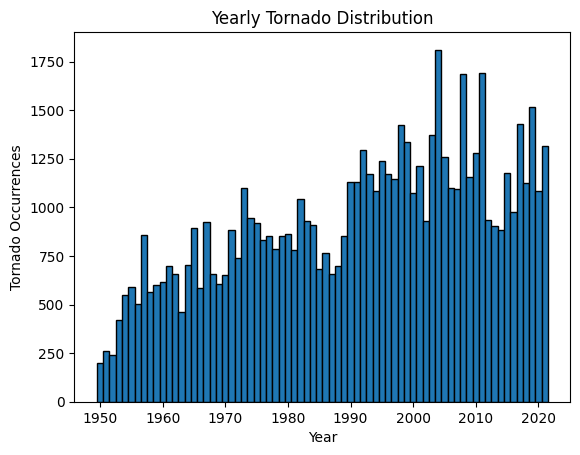

Average yearly tornado occurrences 1950-2021: 937.2638888888889 

Minimum number of occurrences: 201
Year of minimum number of occurrences: 1950 

Maximum number of occurrences: 1811
Year of maximum number of occurrences: 2004


In [5]:
#obtain all unique years in dataset as list
years_set = set(data_matrix[:, 0])
years_unique = list(years_set)
#add 2022 to correctly bin 2021 tornadoes
years_unique.append(2022.0)
#create plot and show
hist_data = plt.hist(data_matrix[:, 0], bins=years_unique, edgecolor="black", align="left")
plt.title("Yearly Tornado Distribution")
plt.xlabel("Year")
plt.ylabel("Tornado Occurrences")
plt.show()
#find average Tornado occurrences
print("Average yearly tornado occurrences 1950-2021:", sum(hist_data[0])/len(hist_data[0]), "\n")
#find minimum number of tornado occurrences and corresponding year
print("Minimum number of occurrences:", int(min(hist_data[0])))
print("Year of minimum number of occurrences:", int(hist_data[1][list(hist_data[0]).index(min(hist_data[0]))]), "\n")
#find maximum number of tornado occurrences and corresponding year
print("Maximum number of occurrences:", int(max(hist_data[0])))
print("Year of maximum number of occurrences:", int(hist_data[1][list(hist_data[0]).index(max(hist_data[0]))]))

From this plot, we can clearly see an increasing trend over the years. This could be caused by any number of things, but the two that seem most likely are increasingly accurate methods of spotting and reporting tornadoes and climate change causing increasingly favorable conditions for tornadoes.

The insights shown by the returned data tell us that the year for the lowest occurrences was 1950, with only 201 tornadoes, and the highest was 2004, with 1811 tornadoes. These are both widely separated from the average of roughly 937.26, indicating the potential for high variation year-to-year.

Next up, let's take a look at a monthly distribution:

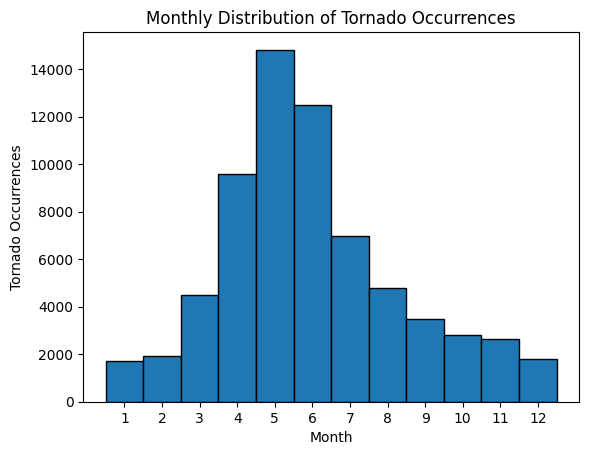

Average monthly tornado occurrences 1950-2021: 78.10532407407408 

Minimum number of occurrences: 1713
Month of minimum number of occurrences: 1 

Maximum number of occurrences: 14814
Month of maximum number of occurrences: 5


In [6]:
#Months list, add 13 to bin correctly
months = [1,2,3,4,5,6,7,8,9,10,11,12,13]
#create and plot
hist_data = plt.hist(data_matrix[:, 1], bins=months, edgecolor="black", align="left")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xlabel("Month")
plt.ylabel("Tornado Occurrences")
plt.title("Monthly Distribution of Tornado Occurrences")
plt.show()
#find average Tornado occurrences
print("Average monthly tornado occurrences 1950-2021:", (sum(hist_data[0])/len(hist_data[0]))/72, "\n")
#find minimum number of tornado occurrences and corresponding month
print("Minimum number of occurrences:", int(min(hist_data[0])))
print("Month of minimum number of occurrences:", int(hist_data[1][list(hist_data[0]).index(min(hist_data[0]))]), "\n")
#find maximum number of tornado occurrences and corresponding month
print("Maximum number of occurrences:", int(max(hist_data[0])))
print("Month of maximum number of occurrences:", int(hist_data[1][list(hist_data[0]).index(max(hist_data[0]))]))

We can see here that the highest number of tornadoes occur in May, at 14816 over the course of the 72-year period described by the dataset. January is the month of the lowest number of occurrences, with only 1713. The average of about 78.105 describes the average number of tornadoes one could expect to find within any single month picked out of the 72-year period covered by the dataset.

Up next, let's analyze the distribution over the strength of the tornadoes:

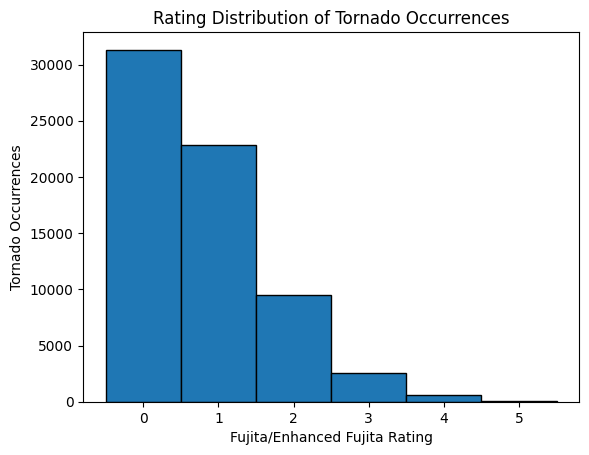

Average rating of tornadoes from 1950-2021: 0.779419241006011 

Least frequent rating: 5
Number of occurrences 59 

Most frequent rating: 0
Number of occurrences: 31316


In [7]:
#Months list, add 6 to bin correctly
ratings = [0,1,2,3,4,5,6]
#create and plot
#exculde -9 ratings
acc_ratings = []
for item in data_matrix[:, 3]:
    if item < 0:
        continue
    else:
        acc_ratings.append(item)
hist_data = plt.hist(acc_ratings, bins=ratings, edgecolor="black", align="left")
plt.xticks([0,1,2,3,4,5])
plt.xlabel("Fujita/Enhanced Fujita Rating")
plt.ylabel("Tornado Occurrences")
plt.title("Rating Distribution of Tornado Occurrences")
plt.show()
#find average rating of occurrences (weighted average)
print("Average rating of tornadoes from 1950-2021:", (hist_data[0][1]/sum(hist_data[0])) + (2*(hist_data[0][2]/sum(hist_data[0]))) + (3*(hist_data[0][3]/sum(hist_data[0]))) + (4*(hist_data[0][4]/sum(hist_data[0]))) + (5*(hist_data[0][5]/sum(hist_data[0]))), "\n")
#find least frequent rating and the number of these
print("Least frequent rating:", int(hist_data[1][list(hist_data[0]).index(min(hist_data[0]))]))
print("Number of occurrences", int(min(hist_data[0])), "\n")
#find most frequent rating and number of these
print("Most frequent rating:", int(hist_data[1][list(hist_data[0]).index(max(hist_data[0]))]))
print("Number of occurrences:", int(max(hist_data[0])))

From the above we see that the most common type of tornadoes by far are the weaker ratings, and truly devastating tornadoes are few and far between, at least on the scale of the 72-year dataset. A rating of zero is the most common, with 31316 in total, and a rating of five is the least common, with only 59 in total. This, alongside the average rating being about 0.7794, backs up my earlier claim of weaker tornadoes being far more common.

I would like to do one last analysis of tornado rating: Analyzing the rating (strength) distribution over time. Let's go ahead and analyze the average rating by year and see what that shows us:

In [8]:
#list to hold sum total for ratings for each decade, as well as total points for calculating averages
yr_rat = [0] * 72
total_points = [0] * 72
#loop through matrix and use calculation to determine correct index(decade) to add the values to
#ignore incorrect -9 values
for row in data_matrix:
    if int(row[3]) < 0:
        continue
    else:
        yr_rat[int(row[0]-1950)] += int(row[3])
        total_points[int(row[0]-1950)] += 1
#compute averages
avg_rat = [0] * 72
for i in range(72):
    avg_rat[i] = yr_rat[i]/total_points[i]

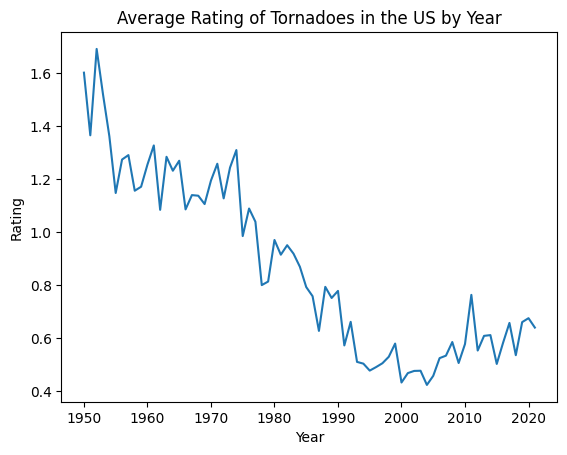

In [9]:
#list for all decades for x axis plotting
yr_list=list(range(1950,2022))
#lat plot
plt.plot(yr_list, avg_rat)
plt.title("Average Rating of Tornadoes in the US by Year")
plt.xlabel("Year")
plt.ylabel("Rating")
plt.show()

As we can see, the line plot indicates a steep downwards trend that then somewhat reverses around the year 2000. I believe that this can be attributed to a couple different things, the first being an increase in reporting abilities over the years, leading to more weak tornadoes being noticed and reported where they would have previously gone unnoticed or unreported. When this accurate reporting caught all the way up to modern times around the year 2000, we found ourselves to be able to accurately report almost every tornado that occurs, thus eliminating this factor of the trend. The new upwards trend is almost certainly attributable to the uptick in violent weather events across not just the US but the world as well due to climate change. I believe that we will see this upwards trend continue in the years to come as the climate becomes more and more unstable.

## __Geographical Analysis of the Data__ ##

Now that we've looked at the other important data in the dataset, it's time to look at the most crucial: location.

To do this, we will use the Python library called Folium to plot the geospatial data given to us by the dataset. Let's start just by plotting each tornado by latitude and longitude and see where that gets us:

In [10]:
#center map on geographical center of the lower 48 and zoom accordingly
mymap = fl.Map(location=[39.833333, -98.583333], zoom_start=4)
mycluster = MarkerCluster().add_to(mymap)
for row in data_matrix:
    fl.Marker(location=[row[4], row[5]], popup=row[3]).add_to(mycluster)
mymap.save("all_tornadoes_map.html")

By doing a quick analysis of the map saved as the HTML file above, one can see that tornado activity appears to be clustered in the center of the country, with the most occurring in the Southern Great Plains in states such as Kansas, Oklahoma, and Texas, and then a secondary concentration in the Deep South, in states like Arkansas, Louisiana, Mississippi, and Alabama. The areas with the least activity are the northeast, northwest, and southwest corners of the country, although the upper Midwest also sees far less than the Great Plains and Deep South.

Now let's do a more interesting analysis, where we find the average location of the tornadoes overall and then the average location for each decade to see if we can find a correlation between them.

The decades will be as follows:
- 1950-1959
- 1960-1969
- 1970-1979
- 1980-1989
- 1990-1999
- 2000-2009
- 2010-2019
- 2020-2021

Note that the last 'decade' is only 2 years instead of 10, and as such that data will be less reliable as a decade average, but it will still be included, as I believe it is beneficial to do so.

In [11]:
#lists to hold sum totals for lat and long for each decade, as well as total points for calculating averages
dec_lat = [0] * 8
dec_long = [0] * 8
total_points = [0] * 8
#loop through matrix and use calculation to determine correct index(decade) to add the values to
for row in data_matrix:
    dec_lat[int((row[0]-1950)//10)] += float(row[4])
    dec_long[int((row[0]-1950)//10)] += float(row[5])
    total_points[int((row[0]-1950)//10)] += 1
#compute averages
avg_lat = [0] * 8
avg_long = [0] * 8
for i in range(8):
    avg_lat[i] = dec_lat[i]/total_points[i]
    avg_long[i] = dec_long[i]/total_points[i]
#compute overall average
avg_lat_overall = sum(dec_lat)/sum(total_points)
avg_long_overall = sum(dec_long)/sum(total_points)

In [12]:
#create map
mymap1 = fl.Map(location=[37.333333, -92.083333], zoom_start=7)
#plot markers for decadal averages
for i in range(8):
    fl.Marker(location=[avg_lat[i], avg_long[i]], popup=str((i*10)+1950) + "\'s", icon=fl.Icon("green")).add_to(mymap1)
#marker for overall average
fl.Marker(location=[avg_lat_overall, avg_long_overall], popup="overall", icon=fl.Icon("red")).add_to(mymap1)
mymap1.save("decadal_averages_map.html")

As we can see from the map saved as the HTML file above, the correlation isn't much and certainly isn't too easy to see, but it can definitely be seen, as 3 of 4 of the points that are east of the overall average point are the last 3 decades, and all 4 of the points to the west are from the 1990s or older. While this isn't too much to go off of, it is interesting enough to warrant some further investigation.

Let's first start by looking at this on some line plots to get a better look at this correlation:

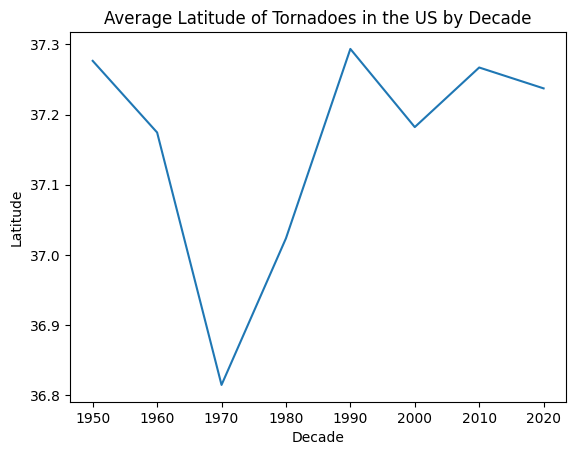

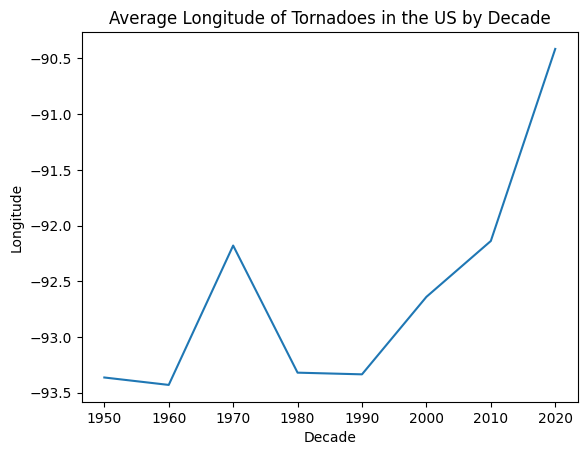

In [13]:
#list for all decades for x axis plotting
decade_list=[1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
#lat plot
plt.plot(decade_list, avg_lat)
plt.title("Average Latitude of Tornadoes in the US by Decade")
plt.xlabel("Decade")
plt.ylabel("Latitude")
plt.show()
#long plot
plt.plot(decade_list, avg_long)
plt.title("Average Longitude of Tornadoes in the US by Decade")
plt.xlabel("Decade")
plt.ylabel("Longitude")
plt.show()

As we can see, there is little correlation between decades and latitude, but between decades and longitude, we see a fairly compelling upwards curve that appears to suggest a shift to the east over time.

Let us delve into this further and break it down all the way to individual years:

In [14]:
#lists to hold sum totals for lat and long for each year, as well as total points for calculating averages
yr_lat = [0] * 72
yr_long = [0] * 72
total_points = [0] * 72
#loop through matrix and use calculation to determine correct index(year) to add the values to
for row in data_matrix:
    yr_lat[int(row[0])-1950] += float(row[4])
    yr_long[int(row[0])-1950] += float(row[5])
    total_points[int(row[0])-1950] += 1
#compute averages
avg_lat = [0] * 72
avg_long = [0] * 72
for i in range(72):
    avg_lat[i] = yr_lat[i]/total_points[i]
    avg_long[i] = yr_long[i]/total_points[i]
#compute overall average
avg_lat_overall = sum(yr_lat)/sum(total_points)
avg_long_overall = sum(yr_long)/sum(total_points)

In [15]:
#create map
mymap2 = fl.Map(location=[37.333333, -92.083333], zoom_start=7)
#plot markers for decadal averages
for i in range(72):
    fl.Marker(location=[avg_lat[i], avg_long[i]], popup=i+1950, icon=fl.Icon("green")).add_to(mymap2)
#marker for overall average
fl.Marker(location=[avg_lat_overall, avg_long_overall], popup="overall", icon=fl.Icon("red")).add_to(mymap2)
mymap2.save("yearly_averages_map.html")

This map is a lot less conclusive and essentially requires the line plot analysis to find any correlation, so let's forge on ahead:

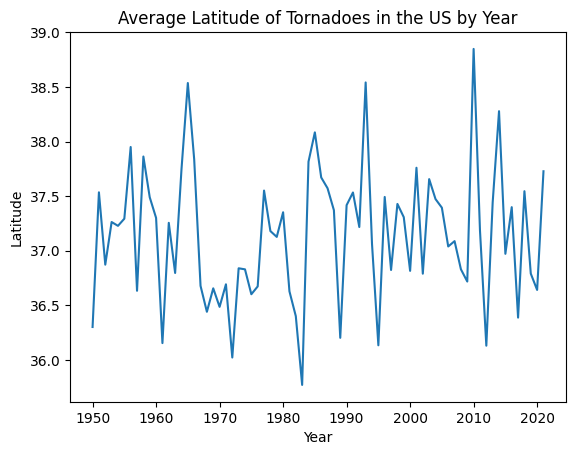

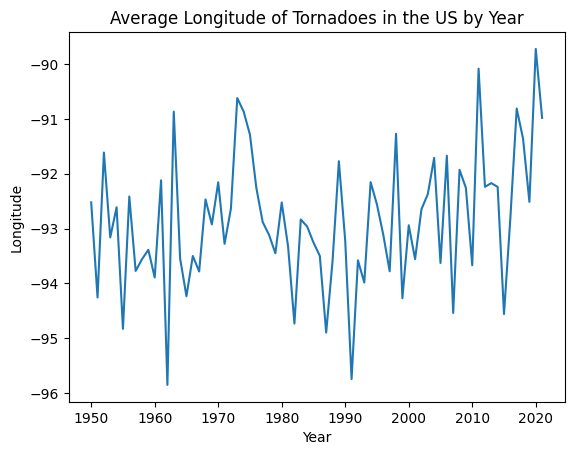

In [16]:
#list for all decades for x axis plotting
yr_list=list(range(1950,2022))
#lat plot
plt.plot(yr_list, avg_lat)
plt.title("Average Latitude of Tornadoes in the US by Year")
plt.xlabel("Year")
plt.ylabel("Latitude")
plt.show()
#long plot
plt.plot(yr_list, avg_long)
plt.title("Average Longitude of Tornadoes in the US by Year")
plt.xlabel("Year")
plt.ylabel("Longitude")
plt.show()

Once again, we see little to no correlation in latitude vs. year, as expected. In longitude vs. year, however, we once again see a slight but definite upwards correlation, indicating an eastward shift in tornado activity year after year.

Before we conclude things here, let's do one final analysis and use the DBSCAN clustering algorithm with a few different input combinations to see if we can derive any useful insights.

In [17]:
#obtain all points for clustering datasets (exclude -9 ratings, all else is valid)
#first includes age, strength, and location
tmp_lst = []
for row in data_matrix:
    if int(row[3]) >= 0:
        tmp_lst.append(row[2:])
clust_matrix1 = np.array(tmp_lst,dtype='d')
#second includes only age and location
tmp_lst = []
for row in data_matrix:
    if int(row[3]) >= 0:
        tmp_lst.append([row[2], row[4], row[5]])
clust_matrix2 = np.array(tmp_lst,dtype='d')

In [18]:
#perform clustering on only age and location to begin
clustering = DBSCAN(eps = 5, min_samples = 1000).fit(clust_matrix2)

In [19]:
#find number of clusters
myset = set(clustering.labels_)
print("Number of clusters:",len(myset))

Number of clusters: 2


As we can see, DBSCAN has found 2 clusters for us. Let's perform some more analysis of these clusters:

In [20]:
clusters = [[],[]]
for i in range(len(clust_matrix2)):
    if int(clustering.labels_[i]) == -1:
        clusters[0].append(clust_matrix2[i])
    elif int(clustering.labels_[i]) == 0:
        clusters[1].append(clust_matrix2[i])
print("Size of cluster 1:", len(clusters[0]))
print("Size of cluster 2:", len(clusters[1]))

Size of cluster 1: 12194
Size of cluster 2: 54684


In [21]:
#perform statistical analysis
#average age of each cluster
tot_age_cl1 = 0
for row in clusters[0]:
    tot_age_cl1 += row[0]
avg_age_cl1 = tot_age_cl1/len(clusters[0])
print("Average age of cluster 1:", avg_age_cl1)
tot_age_cl2 = 0
for row in clusters[1]:
    tot_age_cl2 += row[0]
avg_age_cl2 = tot_age_cl2/len(clusters[1])
print("Average age of cluster 2:", avg_age_cl2)

Average age of cluster 1: 43.40862759784562
Average age of cluster 2: 31.13144153008096


We see that while they are similar in age, there is a definite gap between them. Now, let's find location averages and plot them:

In [22]:
#average locations of each cluster
totlat1 = 0
totlong1 = 0
for row in clusters[0]:
    totlat1 += row[1]
    totlong1 += row[2]
avglat1 = totlat1/len(clusters[0])
avglong1 = totlong1/len(clusters[0])
totlat2 = 0
totlong2 = 0
for row in clusters[1]:
    totlat2 += row[1]
    totlong2 += row[2]
avglat2 = totlat2/len(clusters[1])
avglong2 = totlong2/len(clusters[1])
#create map
mymap3 = fl.Map(location=[37.333333, -92.083333], zoom_start=7)
#plot markers
fl.Marker(location=[avglat1, avglong1], popup=avg_age_cl1, icon=fl.Icon("green")).add_to(mymap3)
fl.Marker(location=[avglat2, avglong2], popup=avg_age_cl2, icon=fl.Icon("red")).add_to(mymap3)
mymap3.save("clustering_map.html")

These clusters being so far apart in terms of size makes it difficult to draw any real conclusions from this analysis, but we can certainly speculate about what the data seems to be showing us. The first thing I take away from this is that the larger cluster is much closer to the midpoint of the two most concentrated areas of tornado activity: the Great Plains and the Deep South. The other cluster is further north and east, which is closer to the more populated areas of the country. This correlates with the older apparent age of the cluster, as more tornadoes would have been spotted in populated areas back in the day without radar or other detection techniques to spot weaker and more remote tornadoes. Besides the above speculation, not much more can be derived at surface value from the clustering shown.

## __Conclusions__ ##

Tornadoes are one of the most fascinating and most dangerous weather phenomena the world has to offer us. The spectacle of witnessing a tornado in person is something that many people, such as myself, dream of being able to do someday. Data analysis projects, like the one you've just finished reading, allow people like me and you to learn more about how these wonders of nature work and how they behave.

This project has uncovered some trends and patterns in tornado activity that would be otherwise difficult if not impossible to derive from simple observation of weather and media reporting. These trends and patterns include a definite uptick in both tornado activity and tornado strength in recent years, indicating a destabilizing climate and more volatile atmosphere. In addition, the sharp increase in tornado occurrence indicates just how far we have come in meteorology and tornado detection and reporting over the years, which has undoubtedly significantly contributed to the meteorological and scientific communities, as well as saved countless lives. We've also noticed that most tornadoes appear to occur in the spring, which would lead us to the conclusion that the atmosphere is more unstable and more conducive to tornado development during that part of the year. Lastly, we have also been able to notice a slight but definite eastward trend in tornado occurrences in the last couple decades. This could indicate any number of things and is the most interesting takeaway from this analysis, in my opinion.

While this project has uncovered a significant amount of the patterns and behaviors of tornadoes in the US, there undoubtedly remain many more waiting to be found and put to use. I wish all my fellow hobbyists and all the researchers, meteorologists, and scientists the absolute best of luck in their endeavors to do just that.

Thank you for taking the time to peruse this project. I hope it has sparked interest or speculation in at least a few of you, as I would consider it a waste if it has failed to do so.